# $B^+ \to K^+ a(\to \mu^+\mu^-)$ at LHCb

In [1]:
from PIL import Image # Reading and manipulating images
import numpy as np # Math stuff
import matplotlib.pyplot as plt # Plot stuff
plt.rcParams.update({'font.size': 12, 'text.usetex': True, 'font.family': 'serif', 'font.serif': ['Computer Modern Roman']}) # Set font size and family
from scipy.interpolate import interp1d, RegularGridInterpolator # Interpolation


## Digitizing the image

[arXiv:1612.07818](https://arxiv.org/abs/1612.07818)

The image is converted to HSV color space, as the hue of each pixel encodes the BR.

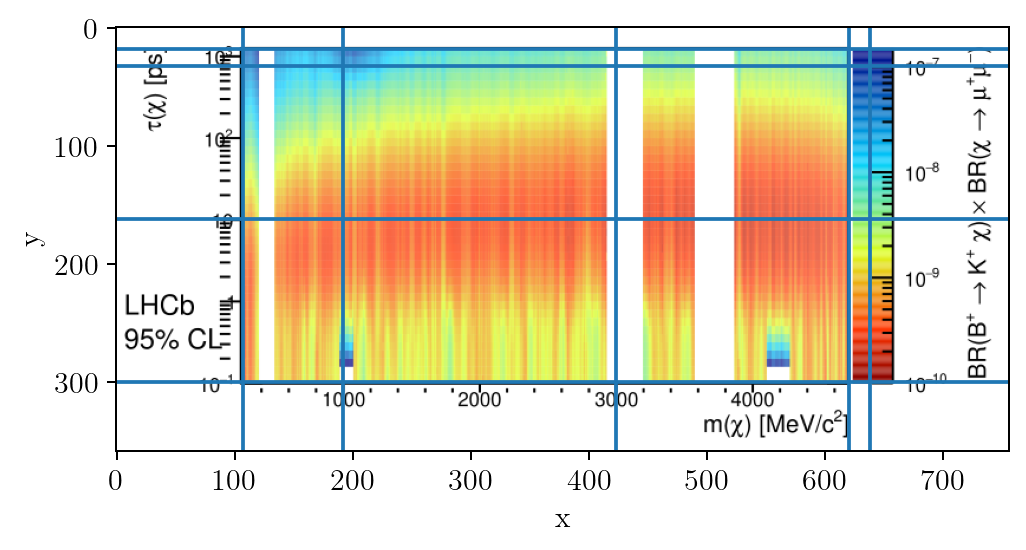

In [2]:
img = Image.open('LHCb_BKmumu.png')
imgH = img.convert('HSV')

plt.figure(dpi=180)
plt.imshow(np.asarray(img))
plt.xlabel('x')
plt.ylabel('y')
plt.axvline(638) #Vertical line along the colorbar
plt.axhline(300) # BR = 1e-10 in the colorbar, tau = 0.1ps
plt.axhline(32) # BR = 1e-7 in the colorbar
plt.axhline(18) #Upper limit in the colorbar, log(BR) = -7 + 14/(300-32)*3 = -6.841

plt.axvline(107) #Begining of the x-axis
plt.axvline(620) # End of the x-axis

plt.axvline(192) # ma = 1GeV
plt.axvline(423) # ma = 3GeV

plt.axhline(162) # tau = 10ps

In [3]:
cbar = {}
for iy, y in enumerate(range(17, 300)):
    cbar[imgH.getpixel((638, y))[0]] = np.linspace(-6.84, -10, 300-17)[iy]


The hue is a monotonical function of the BR, so we can invert it to read the BR of each pixel

Text(0, 0.5, 'Hue')

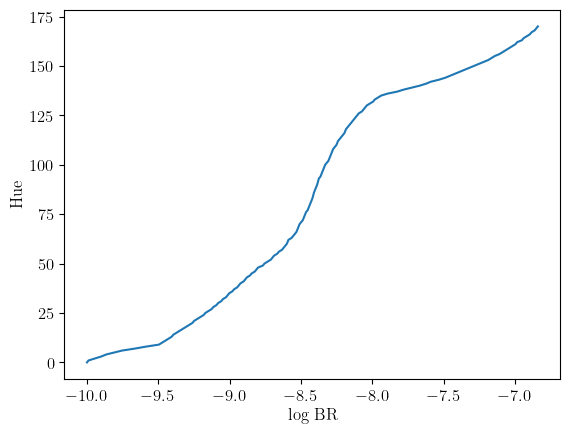

In [4]:
plt.plot(cbar.values(), cbar.keys())
plt.xlabel('log BR')
plt.ylabel('Hue')

In [5]:
interp_color = interp1d(list(cbar.keys()), list(cbar.values()), kind='cubic')

In [6]:
matrix_br = np.full((619-107, 300-19), np.nan)

for ix, x in enumerate(range(107, 619)):
    for iy, y in enumerate(range(19, 300)):
        if img.getpixel((x, y))[:3] != (255, 255, 255):
            hue = min(imgH.getpixel((x, y))[0], max(cbar.keys()))
            matrix_br[ix, iy] = interp_color(hue)

In [7]:
ma = (np.arange(107, 619)-192)/(423-192)*2+1
logtau = -1+(np.arange(19, 300)-300)/(162-300)*2
x_ma, y_logtau = np.meshgrid(ma, logtau)

/tmp/ipykernel_15951/4030726768.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


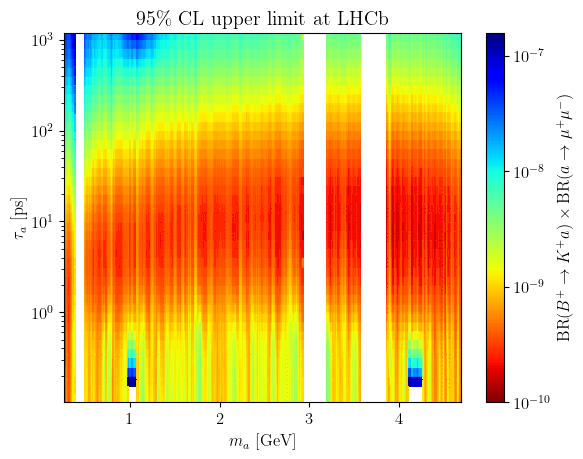

In [8]:
plt.pcolor(x_ma, 10**y_logtau, matrix_br.T, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
cb.set_label(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')
ax= plt.gca()
ax.set_yscale('log')

## Saving and loading

We save as a numpy array containing the grid of logarithms of the BR. The matrix is extended by one row and one column, containing the values of $m_a$ and $\log_{10}\tau_a$ respectively.

In [9]:
matrix_res = np.full((300-19+1, 619-107+1), np.nan)

for ix in range(matrix_br.shape[0]):
    for iy in range(matrix_br.shape[1]):
        if not np.isnan(matrix_br[ix, iy]):
            matrix_res[iy, ix] = matrix_br[ix, iy]

for ix in range(len(logtau)):
    matrix_res[ix, -1] = logtau[ix]

for iy in range(len(ma)):
    matrix_res[-1, iy] = ma[iy]

In [10]:
np.save('../../alpaca/experimental_data/visible/LHCb_BKmumu_displ.npy', matrix_res)

And we can load the matrix and retrieve all the data

In [11]:
m2 = np.load('../../alpaca/experimental_data/visible/LHCb_BKmumu_displ.npy')

In [12]:
ma = m2[-1,:-1]
logtau = m2[:-1,-1]
matrix_br = m2[:-1,:-1]
x_ma, y_logtau = np.meshgrid(ma, logtau)

/tmp/ipykernel_15951/2776747312.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

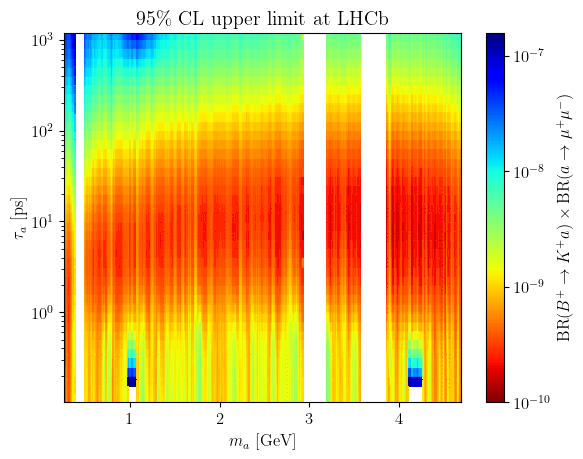

In [13]:
plt.pcolor(x_ma, 10**y_logtau, matrix_br, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
ax= plt.gca()
ax.set_yscale('log')
cb.set_label(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')

## Interpolation

The interpolator already returns `NaN` for points with missing data, i.e. in the charmonium resonances. With the option `bounds_error=False`, it will also return `NaN` for values out of bounds.

In [14]:
interp_br = RegularGridInterpolator((ma, logtau), matrix_br.T, method='linear', bounds_error=False)

In [15]:
ma2 = np.linspace(0, 5.0, 500)
logtau2 = np.linspace(-1, 3.2, 500)
x_ma2, y_logtau2 = np.meshgrid(ma2, logtau2)
points = np.vstack([x_ma2.ravel(), y_logtau2.ravel()]).T

In [16]:
z_br = interp_br(points).reshape(x_ma2.shape)

/tmp/ipykernel_15951/4096416294.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

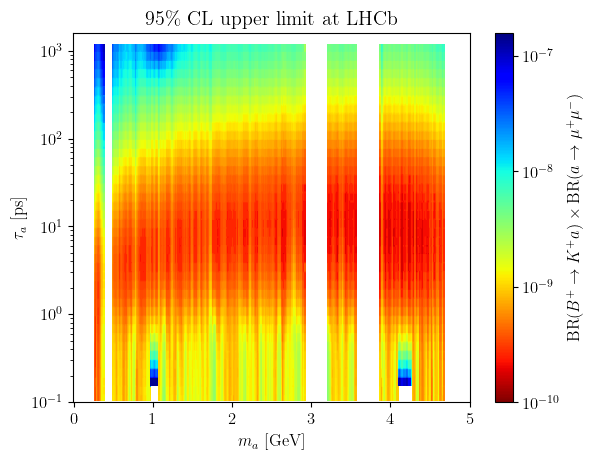

In [17]:
plt.pcolor(x_ma2, 10**y_logtau2, z_br, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
ax= plt.gca()
ax.set_yscale('log')
cb.set_label(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')

Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

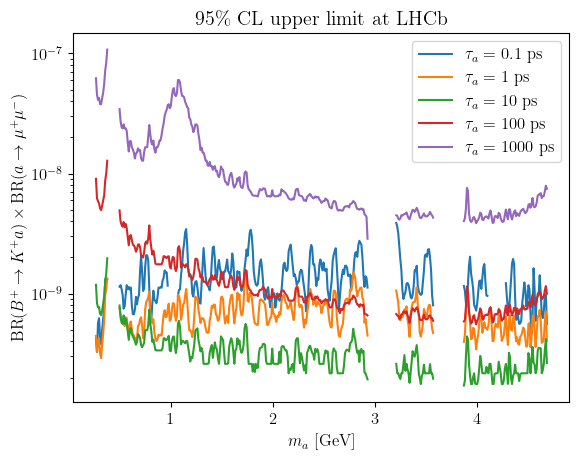

In [18]:
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(0.104*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 0.1$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(1*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 1$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(10*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 10$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(100*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 100$ ps')
plt.semilogy(ma2, 10**interp_br((ma2, np.log10(1000*np.ones_like(ma2)))).flatten(), label=r'$\tau_a = 1000$ ps')
plt.legend()
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\mathrm{BR}(B^+\to K^+ a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.title(r'95\% CL upper limit at LHCb')

In [8]:
from alpaca.experimental_data.classes import MeasurementDisplacedVertexBound
from alpaca.models.model_library import QED_DFSZ, beta, u_DFSZ, d_DFSZ
from alpaca.statistics.chisquared import chi2_obs, combine_chi2
from alpaca.statistics.functions import nsigmas
from alpaca.constants import hbar_GeVps

In [20]:
lhcbbkmumu = MeasurementDisplacedVertexBound('LHCb:...', '../../alpaca/experimental_data/visible/LHCb_BKmumu_displ.npy', 0.95)

In [11]:
ma = np.linspace(0.103, 5.0, 100)
fa = np.logspace(3, 8, 100)

In [12]:
couplings = [QED_DFSZ.get_couplings({beta: np.pi/4}, f).match_run(5.1, 'VA_below', 'leadinglog') for f in fa]
x_ma, y_couplings = np.meshgrid(ma, couplings)
x_ma, y_fa = np.meshgrid(ma, fa)

In [23]:
chi2_bkmumu_displ = chi2_obs(lhcbbkmumu, 'B+ -> K+ mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')

/home/geonosis/.cache/pypoetry/virtualenvs/alpaca-YZhijjtZ-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2458: ComplexWarning: Casting complex values to real discards the imaginary part
  res = asanyarray(outputs, dtype=otypes[0])
/home/geonosis/Documents/alpaca/alp-aca/alpaca/decays/mesons/invisible.py:36: RuntimeWarning: invalid value encountered in sqrt
  return mB**3*abs(gq_eff)**2/(64*np.pi) * f0_BK(ma**2)**2*np.sqrt(kallen(1, mK**2/mB**2, ma**2/mB**2))*(1-mK**2/mB**2)**2


Text(0.5, 1.0, '$B^+ \\to K^+ a(\\to \\mu^+ \\mu^-)$ at LHCb, QED-DFSZ with $\\tan\\beta = 1$')

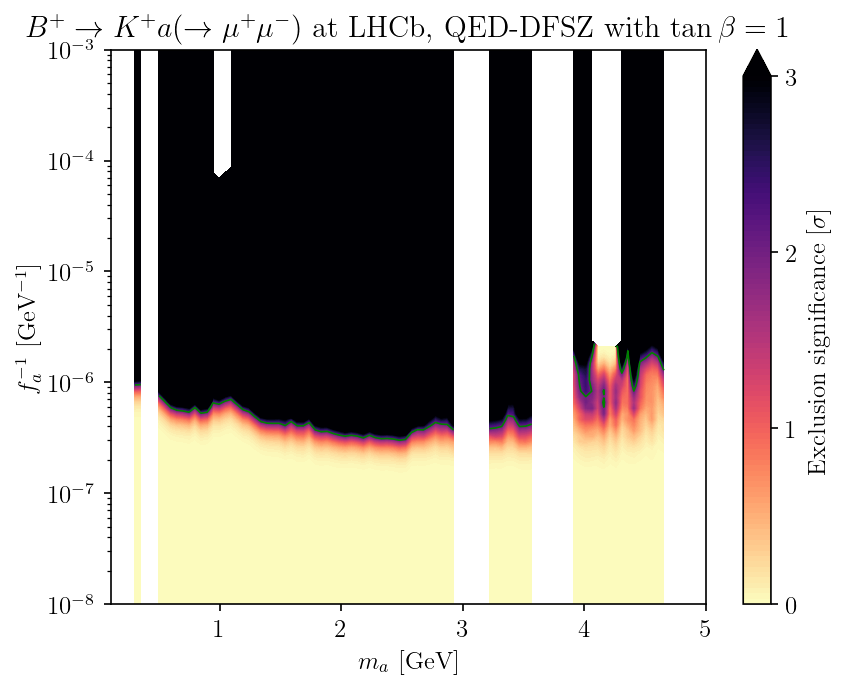

In [24]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkmumu_displ),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkmumu_displ),2), levels=[2], colors='g', linewidths=0.8)
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.title(r'$B^+ \to K^+ a(\to \mu^+ \mu^-)$ at LHCb, QED-DFSZ with $\tan\beta = 1$')

# $B^0 \to K^{*0} \mu^+ \mu^-$

In [25]:
data = np.loadtxt('lhcb_bksmumu.txt', dtype=float, delimiter='\t')

In [26]:
ma = np.arange(214, 4350, step=5)/1000
logtau = np.arange(-25, 75)/25

x_ma, y_logtau = np.meshgrid(ma, logtau)
z_br = np.where(data > 0, np.log10(data), np.nan)

/tmp/ipykernel_15951/521049650.py:5: RuntimeWarning: invalid value encountered in log10
  z_br = np.where(data > 0, np.log10(data), np.nan)


/tmp/ipykernel_15951/1091980128.py:2: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  cb = plt.colorbar()


Text(0.5, 1.0, '95\\% CL upper limit at LHCb')

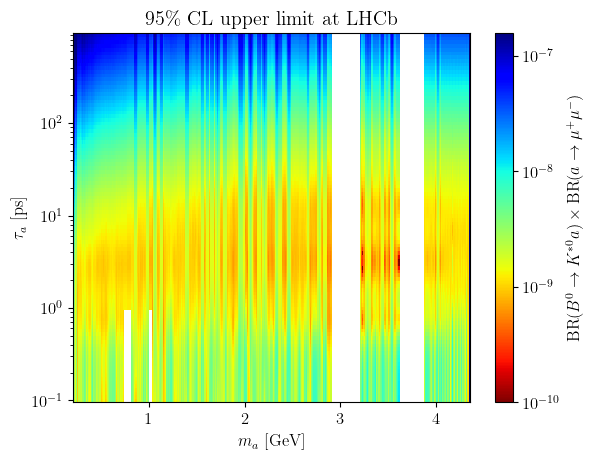

In [27]:
plt.pcolor(x_ma, 10**y_logtau, z_br, cmap = 'jet_r', vmin=-10, vmax=-6.8)
cb = plt.colorbar()
cb.set_ticks([-10, -9, -8, -7])
cb.set_ticklabels([r'$10^{-10}$', r'$10^{-9}$', r'$10^{-8}$', r'$10^{-7}$'])
ax= plt.gca()
ax.set_yscale('log')
cb.set_label(r'$\mathrm{BR}(B^0\to K^{*0} a) \times \mathrm{BR}(a\to \mu^+\mu^-)$')
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\tau_a$ [ps]')
plt.title(r'95\% CL upper limit at LHCb')

In [28]:
matriz_res = np.full((101, 829), np.nan)
matriz_res[:-1,:-1] = z_br
matriz_res[-1,:-1] = ma
matriz_res[:-1,-1] = logtau

In [29]:
np.save('../../alpaca/experimental_data/visible/LHCb_BKsmumu_displ.npy', matriz_res)

In [30]:
lhcbbksmumu = MeasurementDisplacedVertexBound('LHCb:...', '../../alpaca/experimental_data/visible/LHCb_BKsmumu_displ.npy', 0.95)

In [ ]:
ma = np.linspace(0.103, 5.0, 100)
x_ma, y_fa = np.meshgrid(ma, fa)
chi2_bksmumu_displ = chi2_obs(lhcbbksmumu, 'B0 -> K*0 mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')

Text(0.5, 1.0, '$B^0 \\to K^{*0} a(\\to \\mu^+ \\mu^-)$ at LHCb, QED-DFSZ with $\\tan\\beta = 1$')

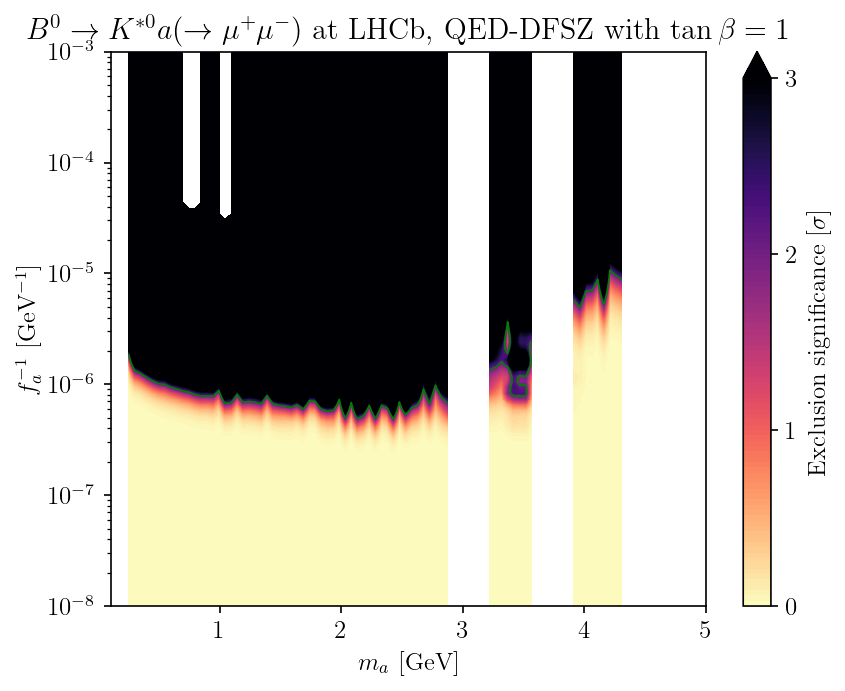

In [32]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2_bksmumu_displ),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bksmumu_displ),2), levels=[2], colors='g', linewidths=0.8)
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.title(r'$B^0 \to K^{*0} a(\to \mu^+ \mu^-)$ at LHCb, QED-DFSZ with $\tan\beta = 1$')

In [33]:
chi2tot = combine_chi2(chi2_bkmumu_displ, chi2_bksmumu_displ)

Text(0.5, 1.0, '$B \\to K a(\\to \\mu^+ \\mu^-)$ at LHCb, QED-DFSZ with $\\tan\\beta = 1$')

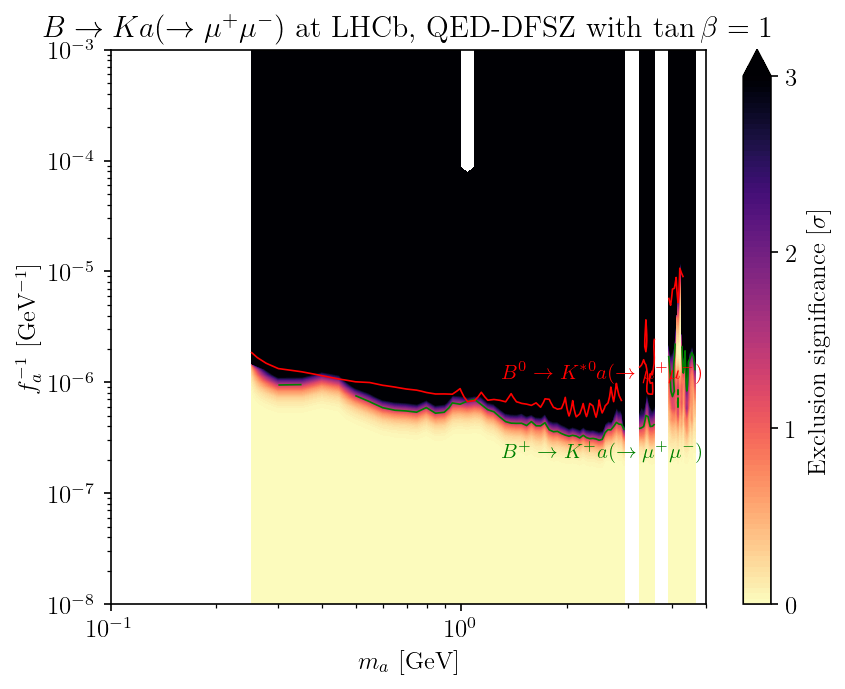

In [34]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2tot),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkmumu_displ),2), levels=[2], colors='g', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bksmumu_displ),2), levels=[2], colors='r', linewidths=0.8)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.xlim(0.1, 5)
plt.annotate(r'$B^+ \to K^+ a(\to \mu^+ \mu^-)$', xy=(1.3, 2.1e-7), color='g', fontsize=10)
plt.annotate(r'$B^0 \to K^{*0} a(\to \mu^+ \mu^-)$', xy=(1.3, 1.1e-6), color='r', fontsize=10)
plt.title(r'$B \to K a(\to \mu^+ \mu^-)$ at LHCb, QED-DFSZ with $\tan\beta = 1$')

# $B^+\to K^+\gamma\gamma$ at BaBar

In [2]:
import pandas as pd

df_babargamma_1 = pd.read_csv('babar_bkphotons_displ_1mm.txt', sep='\t', header=None)
df_babargamma_10 = pd.read_csv('babar_bkphotons_displ_10mm.txt', sep='\t', header=None)
df_babargamma_100 = pd.read_csv('babar_bkphotons_displ_100mm.txt', sep='\t', header=None)

In [3]:
interp_babargamma_1 = interp1d(df_babargamma_1[0], df_babargamma_1[2], kind='linear', bounds_error=False)
interp_babargamma_10 = interp1d(df_babargamma_10[0], df_babargamma_10[2], kind='linear', bounds_error=False)
interp_babargamma_100 = interp1d(df_babargamma_100[0], df_babargamma_100[2], kind='linear', bounds_error=False)

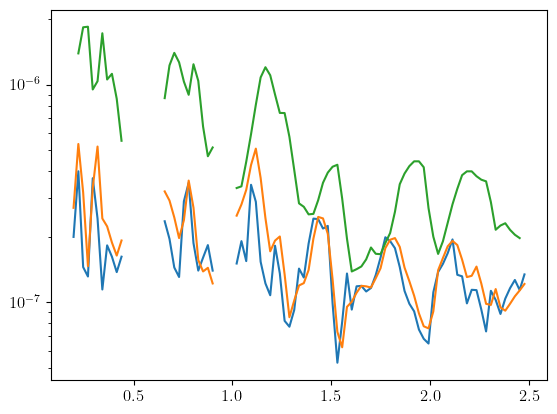

In [4]:
plt.semilogy(np.linspace(0.1, 2.5, 100), interp_babargamma_1(np.linspace(0.1, 2.5, 100)), label=r'$d = 1$ mm')
plt.semilogy(np.linspace(0.1, 2.5, 100), interp_babargamma_10(np.linspace(0.1, 2.5, 100)), label=r'$d = 1$ mm')
plt.semilogy(np.linspace(0.1, 2.5, 100), interp_babargamma_100(np.linspace(0.1, 2.5, 100)), label=r'$d = 1$ mm')

In [5]:
from alpaca.constants import c_nm_per_ps

matrix_res = np.full((4, 101), np.nan)
matrix_res[0,:-1] = interp_babargamma_1(np.linspace(0.19, 2.5, 100))
matrix_res[1,:-1] = interp_babargamma_10(np.linspace(0.19, 2.5, 100))
matrix_res[2,:-1] = interp_babargamma_100(np.linspace(0.19, 2.5, 100))
matrix_res[3,:-1] = np.linspace(0.19, 2.5, 100)
matrix_res[:,-1] = np.log10(np.array([1, 10, 100, np.nan])*1e6/c_nm_per_ps)

In [6]:
np.save('../../alpaca/experimental_data/visible/babar_BKphotons_displ.npy', matrix_res)

In [13]:
babarbkphotons = MeasurementDisplacedVertexBound('LHCb:...', '../../alpaca/experimental_data/visible/babar_BKphotons_displ.npy', 0.95)

In [14]:
chi2_bkphotons_displ = chi2_obs(babarbkphotons, 'B+ -> K+ gamma gamma' , x_ma, y_couplings, y_fa, integrator='no_rge')

/home/jorge/Documents/alpaca/alp-aca/alpaca/decays/mesons/invisible.py:20: RuntimeWarning: invalid value encountered in sqrt
  return mB**3*abs(gq_eff)**2/(64*np.pi) * f0_BK(ma**2)**2*np.sqrt(kallen(1, mK**2/mB**2, ma**2/mB**2))*(1-mK**2/mB**2)**2


Text(0.5, 1.0, '$B^+ \\to K^+ a(\\to \\gamma \\gamma)$ at BaBar, QED-DFSZ with $\\tan\\beta = 1$')

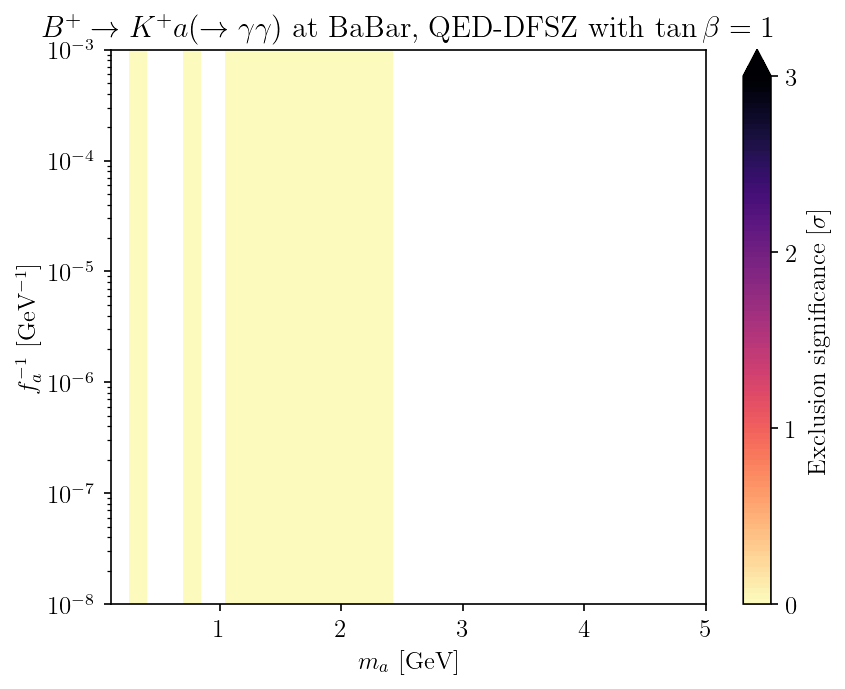

In [15]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkphotons_displ),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkphotons_displ),2), levels=[2], colors='g', linewidths=0.8)
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.title(r'$B^+ \to K^+ a(\to \gamma \gamma)$ at BaBar, QED-DFSZ with $\tan\beta = 1$')

# Fixed target experiments

### CHARM

In [43]:
df_charm_300 = pd.read_csv('CHARM_300.csv')
df_charm_600 = pd.read_csv('CHARM_600.csv')
df_charm_1200 = pd.read_csv('CHARM_1200.csv')
df_charm_2400 = pd.read_csv('CHARM_2400.csv')

In [44]:
interp_charm_300 = interp1d(np.log10(df_charm_300['tau_ps']), np.log10(df_charm_300['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_charm_600 = interp1d(np.log10(df_charm_600['tau_ps']), np.log10(df_charm_600['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_charm_1200 = interp1d(np.log10(df_charm_1200['tau_ps']), np.log10(df_charm_1200['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_charm_2400 = interp1d(np.log10(df_charm_2400['tau_ps']), np.log10(df_charm_2400['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')

In [45]:
matrix_res = np.full((101, 5), np.nan)
matrix_res[:-1,0] = interp_charm_300(np.linspace(np.log10(252), 5.97, 100))
matrix_res[:-1,1] = interp_charm_600(np.linspace(np.log10(252), 5.97, 100))
matrix_res[:-1,2] = interp_charm_1200(np.linspace(np.log10(252), 5.97, 100))
matrix_res[:-1,3] = interp_charm_2400(np.linspace(np.log10(252), 5.97, 100))
matrix_res[:-1,4] = np.linspace(np.log10(252), 5.97, 100)
matrix_res[-1,:] = [0.300, 0.600, 1.200, 2.400, np.nan]

Text(0, 0.5, '$\\mathrm{BR}(B\\to K a)\\times \\mathrm{BR}(a\\to \\mu^+\\mu^-)$')

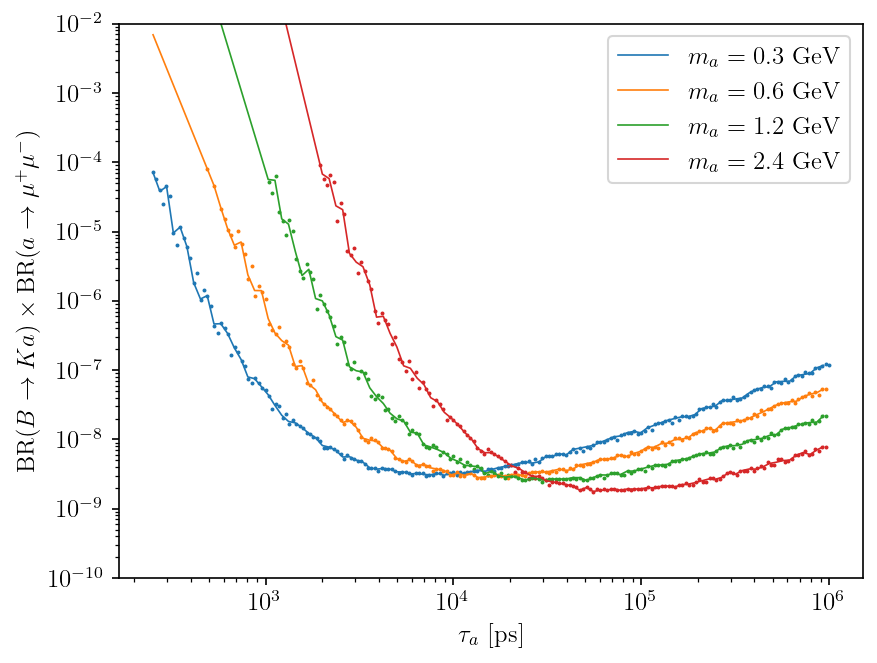

In [46]:
plt.figure(dpi=150)
plt.plot(np.logspace(np.log10(252), 5.97, 100), 10**interp_charm_300(np.linspace(np.log10(252), 5.97, 100)), lw=0.8, label=r'$m_a = 0.3$ GeV')
plt.scatter(df_charm_300['tau_ps'], df_charm_300['BR'], s=0.8)
plt.plot(np.logspace(np.log10(252), 5.97, 100), 10**interp_charm_600(np.linspace(np.log10(252), 5.97, 100)), lw=0.8, label=r'$m_a = 0.6$ GeV')
plt.scatter(df_charm_600['tau_ps'],df_charm_600['BR'], s=0.8)
plt.plot(np.logspace(np.log10(252), 5.97, 100), 10**interp_charm_1200(np.linspace(np.log10(252), 5.97, 100)), lw=0.8, label=r'$m_a = 1.2$ GeV')
plt.scatter(df_charm_1200['tau_ps'],df_charm_1200['BR'], s=0.8)
plt.plot(np.logspace(np.log10(252), 5.97, 100), 10**interp_charm_2400(np.linspace(np.log10(252), 5.97, 100)), lw=0.8, label=r'$m_a = 2.4$ GeV')
plt.scatter(df_charm_2400['tau_ps'],df_charm_2400['BR'], s=0.8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1e-10, 1e-2)
plt.legend()
plt.xlabel(r'$\tau_a$ [ps]')
plt.ylabel(r'$\mathrm{BR}(B\to K a)\times \mathrm{BR}(a\to \mu^+\mu^-)$')

In [47]:
np.save('../../alpaca/experimental_data/visible/CHARM_BKmumu_displ.npy', matrix_res)

### NA62

In [48]:
df_na62_300 = pd.read_csv('NA62_300.csv')
df_na62_600 = pd.read_csv('NA62_600.csv')
df_na62_1200 = pd.read_csv('NA62_1200.csv')
df_na62_2400 = pd.read_csv('NA62_2400.csv')

In [49]:
interp_na62_300 = interp1d(np.log10(df_na62_300['tau_ps']), np.log10(df_na62_300['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_na62_600 = interp1d(np.log10(df_na62_600['tau_ps']), np.log10(df_na62_600['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_na62_1200 = interp1d(np.log10(df_na62_1200['tau_ps']), np.log10(df_na62_1200['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_na62_2400 = interp1d(np.log10(df_na62_2400['tau_ps']), np.log10(df_na62_2400['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')

In [50]:
tau_grid = np.linspace(np.log10(np.min(df_na62_300['tau_ps'])), 6.0, 100)
matrix_res = np.full((101, 5), np.nan)
matrix_res[:-1,0] = interp_na62_300(tau_grid)
matrix_res[:-1,1] = interp_na62_600(tau_grid)
matrix_res[:-1,2] = interp_na62_1200(tau_grid)
matrix_res[:-1,3] = interp_na62_2400(tau_grid)
matrix_res[:-1,4] = tau_grid
matrix_res[-1,:] = [0.300, 0.600, 1.200, 2.400, np.nan]

Text(0, 0.5, '$\\mathrm{BR}(B\\to K a)\\times \\mathrm{BR}(a\\to \\mu^+\\mu^-)$')

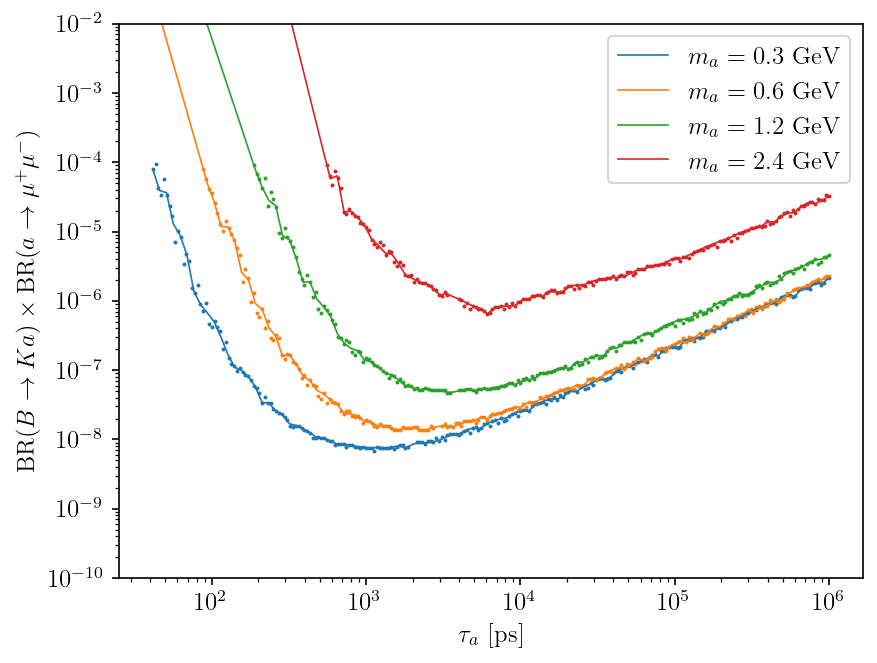

In [51]:
plt.figure(dpi=150)
tau_loggrid = np.logspace(np.log10(np.min(df_na62_300['tau_ps'])), 6.0, 100)
plt.plot(tau_loggrid, 10**interp_na62_300(tau_grid), lw=0.8, label=r'$m_a = 0.3$ GeV')
plt.scatter(df_na62_300['tau_ps'], df_na62_300['BR'], s=0.8)
plt.plot(tau_loggrid, 10**interp_na62_600(tau_grid), lw=0.8, label=r'$m_a = 0.6$ GeV')
plt.scatter(df_na62_600['tau_ps'],df_na62_600['BR'], s=0.8)
plt.plot(tau_loggrid, 10**interp_na62_1200(tau_grid), lw=0.8, label=r'$m_a = 1.2$ GeV')
plt.scatter(df_na62_1200['tau_ps'],df_na62_1200['BR'], s=0.8)
plt.plot(tau_loggrid, 10**interp_na62_2400(tau_grid), lw=0.8, label=r'$m_a = 2.4$ GeV')
plt.scatter(df_na62_2400['tau_ps'],df_na62_2400['BR'], s=0.8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1e-10, 1e-2)
plt.legend()
plt.xlabel(r'$\tau_a$ [ps]')
plt.ylabel(r'$\mathrm{BR}(B\to K a)\times \mathrm{BR}(a\to \mu^+\mu^-)$')

In [52]:
np.save('../../alpaca/experimental_data/visible/NA62_BKmumu_displ.npy', matrix_res)

### SHiP

In [53]:
df_ship_300 = pd.read_csv('SHiP_300.csv')
df_ship_600 = pd.read_csv('SHiP_600.csv')
df_ship_1200 = pd.read_csv('SHiP_1200.csv')
df_ship_2400 = pd.read_csv('SHiP_2400.csv')

In [54]:
interp_ship_300 = interp1d(np.log10(df_ship_300['tau_ps']), np.log10(df_ship_300['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_ship_600 = interp1d(np.log10(df_ship_600['tau_ps']), np.log10(df_ship_600['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_ship_1200 = interp1d(np.log10(df_ship_1200['tau_ps']), np.log10(df_ship_1200['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')
interp_ship_2400 = interp1d(np.log10(df_ship_2400['tau_ps']), np.log10(df_ship_2400['BR']), kind='linear', bounds_error=False, fill_value='extrapolate')

In [55]:
tau_grid = np.linspace(np.log10(np.min(df_ship_300['tau_ps'])), 6.0, 100)
matrix_res = np.full((101, 5), np.nan)
matrix_res[:-1,0] = interp_ship_300(tau_grid)
matrix_res[:-1,1] = interp_ship_600(tau_grid)
matrix_res[:-1,2] = interp_ship_1200(tau_grid)
matrix_res[:-1,3] = interp_ship_2400(tau_grid)
matrix_res[:-1,4] = tau_grid
matrix_res[-1,:] = [0.300, 0.600, 1.200, 2.400, np.nan]

Text(0, 0.5, '$\\mathrm{BR}(B\\to K a)\\times \\mathrm{BR}(a\\to \\mu^+\\mu^-)$')

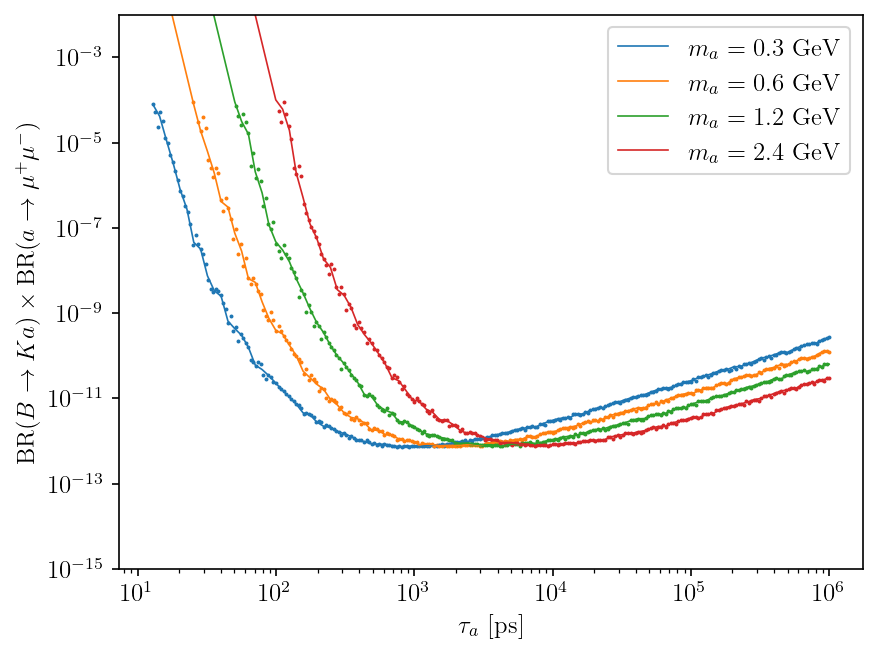

In [56]:
plt.figure(dpi=150)
tau_loggrid = np.logspace(np.log10(np.min(df_ship_300['tau_ps'])), 6.0, 100)
plt.plot(tau_loggrid, 10**interp_ship_300(tau_grid), lw=0.8, label=r'$m_a = 0.3$ GeV')
plt.scatter(df_ship_300['tau_ps'], df_ship_300['BR'], s=0.8)
plt.plot(tau_loggrid, 10**interp_ship_600(tau_grid), lw=0.8, label=r'$m_a = 0.6$ GeV')
plt.scatter(df_ship_600['tau_ps'],df_ship_600['BR'], s=0.8)
plt.plot(tau_loggrid, 10**interp_ship_1200(tau_grid), lw=0.8, label=r'$m_a = 1.2$ GeV')
plt.scatter(df_ship_1200['tau_ps'],df_ship_1200['BR'], s=0.8)
plt.plot(tau_loggrid, 10**interp_ship_2400(tau_grid), lw=0.8, label=r'$m_a = 2.4$ GeV')
plt.scatter(df_ship_2400['tau_ps'],df_ship_2400['BR'], s=0.8)
ax = plt.gca()
ax.set_yscale('log')
ax.set_xscale('log')
plt.ylim(1e-15, 1e-2)
plt.legend()
plt.xlabel(r'$\tau_a$ [ps]')
plt.ylabel(r'$\mathrm{BR}(B\to K a)\times \mathrm{BR}(a\to \mu^+\mu^-)$')

In [57]:
np.save('../../alpaca/experimental_data/visible/SHiP_BKmumu_displ.npy', matrix_res)

## Exclusion regions

In [58]:
charmbkmumu = MeasurementDisplacedVertexBound('CHARM:...', '../../alpaca/experimental_data/visible/CHARM_BKmumu_displ.npy', 0.95)

In [59]:
na62bkmumu = MeasurementDisplacedVertexBound('NA62:...', '../../alpaca/experimental_data/visible/NA62_BKmumu_displ.npy', 0.95)

In [60]:
shipbkmumu = MeasurementDisplacedVertexBound('SHiP:...', '../../alpaca/experimental_data/visible/SHiP_BKmumu_displ.npy', 0.95)

In [61]:
chi2_charm_displ = chi2_obs(charmbkmumu, 'B+ -> K+ mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')

/home/geonosis/.cache/pypoetry/virtualenvs/alpaca-YZhijjtZ-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2458: ComplexWarning: Casting complex values to real discards the imaginary part
  res = asanyarray(outputs, dtype=otypes[0])
/home/geonosis/Documents/alpaca/alp-aca/alpaca/decays/mesons/invisible.py:36: RuntimeWarning: invalid value encountered in sqrt
  return mB**3*abs(gq_eff)**2/(64*np.pi) * f0_BK(ma**2)**2*np.sqrt(kallen(1, mK**2/mB**2, ma**2/mB**2))*(1-mK**2/mB**2)**2


In [62]:
chi2_na62_displ = chi2_obs(na62bkmumu, 'B+ -> K+ mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')

In [63]:
chi2_ship_displ = chi2_obs(shipbkmumu, 'B+ -> K+ mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')

Text(0.5, 1.0, '$B \\to K a(\\to \\mu^+ \\mu^-)$ at CHARM, QED-DFSZ with $\\tan\\beta = 1$')

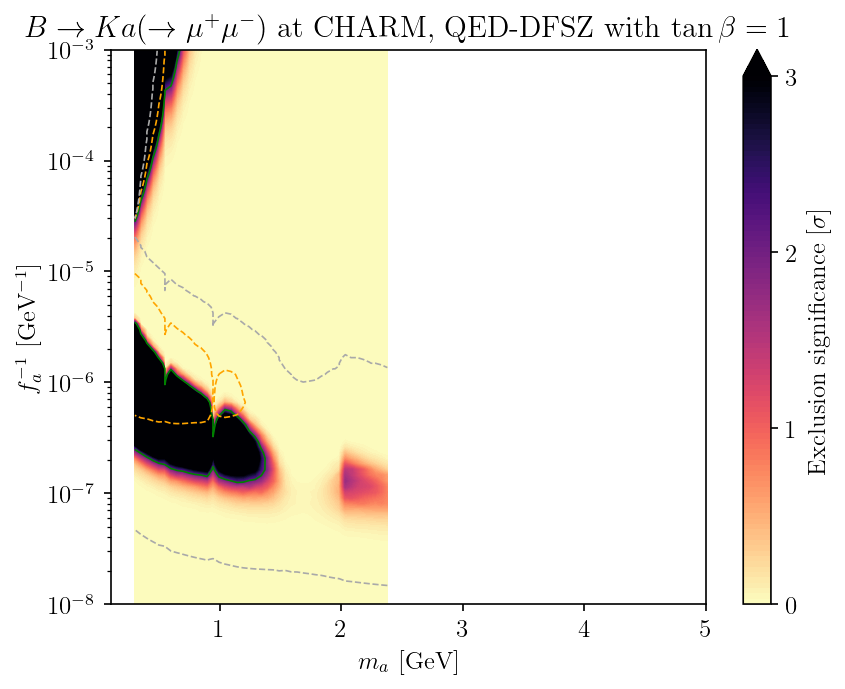

In [64]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2_charm_displ),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_charm_displ),2), levels=[2], colors='g', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_na62_displ),2), levels=[2], colors='orange', linewidths=0.8, linestyles='dashed')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_ship_displ),2), levels=[2], colors='darkgray', linewidths=0.8, linestyles='dashed')
ax = plt.gca()
#ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.title(r'$B \to K a(\to \mu^+ \mu^-)$ at CHARM, QED-DFSZ with $\tan\beta = 1$')

In [65]:
chi2tot = combine_chi2(chi2_bkmumu_displ, chi2_bksmumu_displ, chi2_charm_displ)

Text(0.5, 1.0, '$B \\to K a(\\to \\mu^+ \\mu^-)$, QED-DFSZ with $\\tan\\beta = 1$')

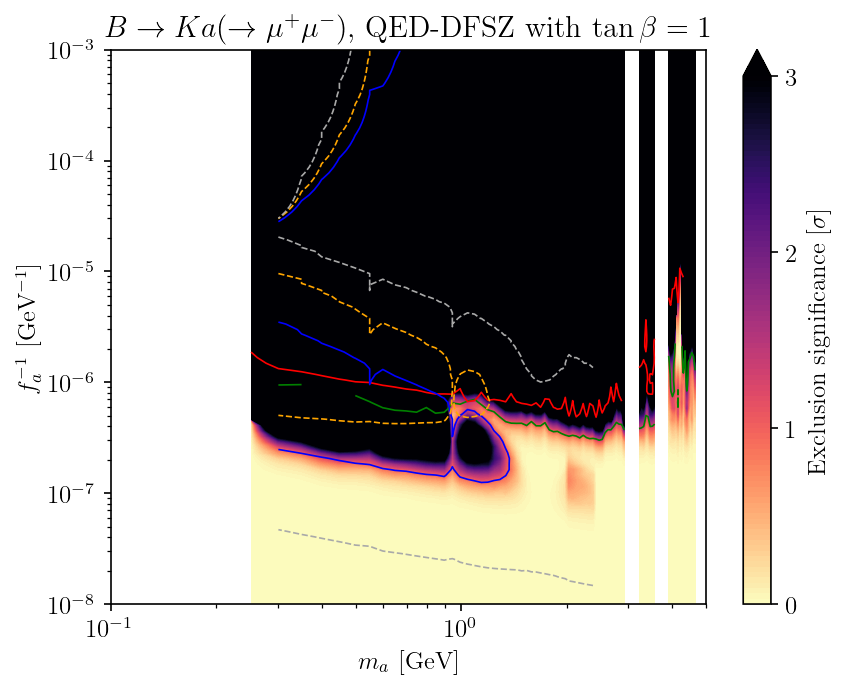

In [66]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2tot),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkmumu_displ),2), levels=[2], colors='g', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bksmumu_displ),2), levels=[2], colors='r', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_charm_displ),2), levels=[2], colors='b', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_na62_displ),2), levels=[2], colors='orange', linewidths=0.8, linestyles='dashed')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_ship_displ),2), levels=[2], colors='darkgray', linewidths=0.8, linestyles='dashed')
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.xlim(0.1, 5)
#plt.annotate(r'$B^+ \to K^+ a(\to \mu^+ \mu^-)$', xy=(1.3, 2.1e-7), color='g', fontsize=10)
#plt.annotate(r'$B^0 \to K^{*0} a(\to \mu^+ \mu^-)$', xy=(1.3, 1.1e-6), color='r', fontsize=10)
plt.title(r'$B \to K a(\to \mu^+ \mu^-)$, QED-DFSZ with $\tan\beta = 1$')

In [67]:
from alpaca.experimental_data.measurements_exp import belleII_bptoknunu_lightmediator, babar_btoksnunu_lightmediator

In [68]:
chi2_bkinv_belleII = chi2_obs(belleII_bptoknunu_lightmediator, 'B+ -> K+ a' , x_ma, y_couplings, y_fa, integrator='no_rge')

/home/geonosis/Documents/alpaca/alp-aca/alpaca/experimental_data/classes.py:77: RuntimeWarning: invalid value encountered in sqrt
  pa_parent = np.sqrt(kallen(self.mass_parent**2, ma**2, self.mass_sibling**2))/(2*self.mass_parent)
/home/geonosis/Documents/alpaca/alp-aca/alpaca/decays/mesons/invisible.py:36: RuntimeWarning: invalid value encountered in sqrt
  return mB**3*abs(gq_eff)**2/(64*np.pi) * f0_BK(ma**2)**2*np.sqrt(kallen(1, mK**2/mB**2, ma**2/mB**2))*(1-mK**2/mB**2)**2


In [69]:
chi2_bkinv_babar = chi2_obs(babar_btoksnunu_lightmediator, 'B0 -> K*0 a' , x_ma, y_couplings, y_fa, integrator='no_rge')

/home/geonosis/.cache/pypoetry/virtualenvs/alpaca-YZhijjtZ-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2458: ComplexWarning: Casting complex values to real discards the imaginary part
  res = asanyarray(outputs, dtype=otypes[0])
/home/geonosis/Documents/alpaca/alp-aca/alpaca/experimental_data/classes.py:77: RuntimeWarning: invalid value encountered in sqrt
  pa_parent = np.sqrt(kallen(self.mass_parent**2, ma**2, self.mass_sibling**2))/(2*self.mass_parent)
/home/geonosis/.cache/pypoetry/virtualenvs/alpaca-YZhijjtZ-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2458: ComplexWarning: Casting complex values to real discards the imaginary part
  res = asanyarray(outputs, dtype=otypes[0])


In [70]:
chi2tot = combine_chi2(chi2_bkinv_belleII, chi2_bkinv_babar, chi2_bkmumu_displ, chi2_bksmumu_displ, chi2_charm_displ)

In [71]:
belleII_bkmumu = MeasurementDisplacedVertexBound('Belle II:...', '../../alpaca/experimental_data/visible/belleII_BKmumu_displ.npy', 0.95)
belleII_b0k0mumu = MeasurementDisplacedVertexBound('Belle II:...', '../../alpaca/experimental_data/visible/belleII_B0K0smumu_displ.npy', 0.95)
belleII_bkee = MeasurementDisplacedVertexBound('Belle II:...', '../../alpaca/experimental_data/visible/belleII_BKee_displ.npy', 0.95)
belleII_b0k0ee = MeasurementDisplacedVertexBound('Belle II:...', '../../alpaca/experimental_data/visible/belleII_B0K0see_displ.npy', 0.95)

In [72]:
chi2_belleII_bkmumu = chi2_obs(belleII_bkmumu, 'B+ -> K+ mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')
chi2_belleII_b0k0mumu = chi2_obs(belleII_b0k0mumu, 'B0 -> K*0 mu mu' , x_ma, y_couplings, y_fa, integrator='no_rge')
chi2_belleII_bkee = chi2_obs(belleII_bkee, 'B+ -> K+ e e' , x_ma, y_couplings, y_fa, integrator='no_rge')
chi2_belleII_b0k0ee = chi2_obs(belleII_b0k0ee, 'B0 -> K*0 e e' , x_ma, y_couplings, y_fa, integrator='no_rge')

/home/geonosis/.cache/pypoetry/virtualenvs/alpaca-YZhijjtZ-py3.12/lib/python3.12/site-packages/numpy/lib/function_base.py:2458: ComplexWarning: Casting complex values to real discards the imaginary part
  res = asanyarray(outputs, dtype=otypes[0])
/home/geonosis/Documents/alpaca/alp-aca/alpaca/decays/mesons/invisible.py:36: RuntimeWarning: invalid value encountered in sqrt
  return mB**3*abs(gq_eff)**2/(64*np.pi) * f0_BK(ma**2)**2*np.sqrt(kallen(1, mK**2/mB**2, ma**2/mB**2))*(1-mK**2/mB**2)**2


In [73]:
chi2tot = combine_chi2(chi2_bkinv_belleII, chi2_bkinv_babar, chi2_bkmumu_displ, chi2_bksmumu_displ, chi2_charm_displ, chi2_belleII_bkmumu, chi2_belleII_b0k0mumu, chi2_belleII_bkee, chi2_belleII_b0k0ee)

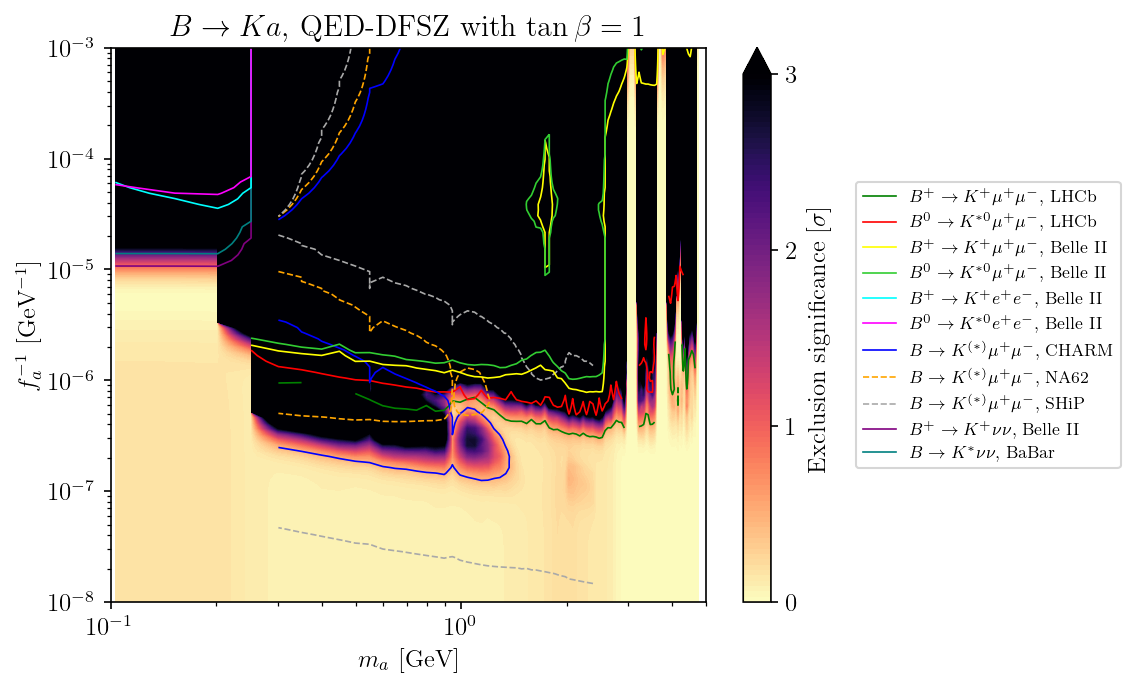

In [74]:
plt.figure(dpi=150)
pl = plt.contourf(x_ma, 1/y_fa, nsigmas(np.real(chi2tot),2), levels=list(np.linspace(0, 3, 100)), cmap='magma_r', vmax=3, extend='max')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkmumu_displ),2), levels=[2], colors='g', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bksmumu_displ),2), levels=[2], colors='r', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_charm_displ),2), levels=[2], colors='b', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkinv_belleII),2), levels=[2], colors='purple', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_bkinv_babar),2), levels=[2], colors='teal', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_na62_displ),2), levels=[2], colors='orange', linewidths=0.8, linestyles='dashed')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_ship_displ),2), levels=[2], colors='darkgray', linewidths=0.8, linestyles='dashed')
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_belleII_bkmumu),2), levels=[2], colors='yellow', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_belleII_b0k0mumu),2), levels=[2], colors='limegreen', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_belleII_bkee),2), levels=[2], colors='cyan', linewidths=0.8)
plt.contour(x_ma, 1/y_fa, nsigmas(np.real(chi2_belleII_b0k0ee),2), levels=[2], colors='magenta', linewidths=0.8)
ax = plt.gca()
ax.set_xscale('log')
ax.set_yscale('log')
cb = plt.colorbar(pl, extend='max')
cb.set_label(r'Exclusion significance [$\sigma$]')
cb.set_ticks([0, 1, 2, 3])
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$f_a^{-1}$ [GeV$^{-1}$]')
plt.xlim(0.1, 5)
#plt.annotate(r'$B^+ \to K^+ a(\to \mu^+ \mu^-)$', xy=(1.3, 2.1e-7), color='g', fontsize=10)
#plt.annotate(r'$B^0 \to K^{*0} a(\to \mu^+ \mu^-)$', xy=(1.3, 1.1e-6), color='r', fontsize=10)
plt.title(r'$B \to K a$, QED-DFSZ with $\tan\beta = 1$')
legend_elements = [plt.Line2D([0], [0], color=c, label=l, ls=ls, lw=0.8)
                   for c, l, ls in zip(['g', 'r', 'yellow', 'limegreen', 'cyan', 'magenta', 'b', 'orange', 'darkgray', 'purple', 'teal'], [r'$B^+\to K^+ \mu^+ \mu^-$, LHCb', r'$B^0\to K^{*0} \mu^+ \mu^-$, LHCb', r'$B^+\to K^+ \mu^+ \mu^-$, Belle II', r'$B^0\to K^{*0} \mu^+ \mu^-$, Belle II', r'$B^+\to K^+ e^+ e^-$, Belle II', r'$B^0\to K^{*0} e^+ e^-$, Belle II', r'$B \to K^{(*)} \mu^+\mu^-$, CHARM', r'$B \to K^{(*)} \mu^+\mu^-$, NA62', r'$B \to K^{(*)} \mu^+\mu^-$, SHiP', r'$B^+ \to K^+ \nu\nu$, Belle II', r'$B \to K^* \nu\nu$, BaBar'], ['solid']*7+['dashed']*2+['solid']*2)]
plt.legend(handles = legend_elements, loc='center left', bbox_to_anchor=(1, 0.5), borderaxespad=9, fontsize=8)

## $K \to \pi \mathrm{inv}$ at NA62

In [3]:
import pandas as pd

In [16]:
df_na62_inf = pd.read_csv('na62_kpiX_inf.csv')
df_na62_5ns = pd.read_csv('na62_kpiX_5ns.csv')
df_na62_2ns = pd.read_csv('na62_kpiX_2ns.csv')
df_na62_1ns = pd.read_csv('na62_kpiX_1ns.csv')
df_na62_500ps = pd.read_csv('na62_kpiX_500ps.csv')
df_na62_200ps = pd.read_csv('na62_kpiX_200ps.csv')
df_na62_100ps = pd.read_csv('na62_kpiX_100ps.csv')

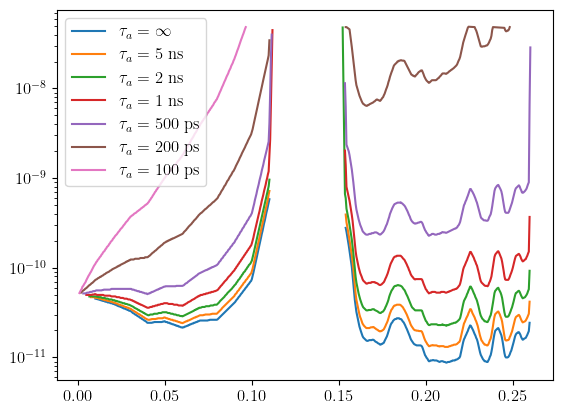

In [17]:
plt.semilogy(df_na62_inf['ma'], df_na62_inf['BR'], label=r'$\tau_a = \infty$')
plt.semilogy(df_na62_5ns['ma'], df_na62_5ns['BR'], label=r'$\tau_a = 5$ ns')
plt.semilogy(df_na62_2ns['ma'], df_na62_2ns['BR'], label=r'$\tau_a = 2$ ns')
plt.semilogy(df_na62_1ns['ma'], df_na62_1ns['BR'], label=r'$\tau_a = 1$ ns')
plt.semilogy(df_na62_500ps['ma'], df_na62_500ps['BR'], label=r'$\tau_a = 500$ ps')
plt.semilogy(df_na62_200ps['ma'], df_na62_200ps['BR'], label=r'$\tau_a = 200$ ps')
plt.semilogy(df_na62_100ps['ma'], df_na62_100ps['BR'], label=r'$\tau_a = 100$ ps')
plt.legend()

In [39]:
interp_na62_kpi_inf = interp1d(df_na62_inf['ma'], np.log10(df_na62_inf['BR']), kind='linear', bounds_error=False)
interp_na62_kpi_5ns = interp1d(df_na62_5ns['ma'], np.log10(df_na62_5ns['BR']), kind='linear', bounds_error=False)
interp_na62_kpi_2ns = interp1d(df_na62_2ns['ma'], np.log10(df_na62_2ns['BR']), kind='linear', bounds_error=False)
interp_na62_kpi_1ns = interp1d(df_na62_1ns['ma'], np.log10(df_na62_1ns['BR']), kind='linear', bounds_error=False)
interp_na62_kpi_500ps = interp1d(df_na62_500ps['ma'], np.log10(df_na62_500ps['BR']), kind='linear', bounds_error=False)
interp_na62_kpi_200ps = interp1d(df_na62_200ps['ma'], np.log10(df_na62_200ps['BR']), kind='linear', bounds_error=False)
interp_na62_kpi_100ps = interp1d(df_na62_100ps['ma'], np.log10(df_na62_100ps['BR']), kind='linear', bounds_error=False)

In [31]:
ma = np.hstack([np.linspace(0, 0.115, 100), np.linspace(0.15, 0.26, 100)])

In [44]:
matrix_res = np.full((201, 8), np.nan)
matrix_res[:-1,0] = interp_na62_kpi_100ps(ma)
matrix_res[:-1,1] = interp_na62_kpi_200ps(ma)
matrix_res[:-1,2] = interp_na62_kpi_500ps(ma)
matrix_res[:-1,3] = interp_na62_kpi_1ns(ma)
matrix_res[:-1,4] = interp_na62_kpi_2ns(ma)
matrix_res[:-1,5] = interp_na62_kpi_5ns(ma)
matrix_res[:-1,6] = interp_na62_kpi_inf(ma)
matrix_res[:-1,7] = ma
matrix_res[-1,:] = np.log10(np.array([100, 200, 500, 1000, 2000, 5000, 10000, np.nan]))

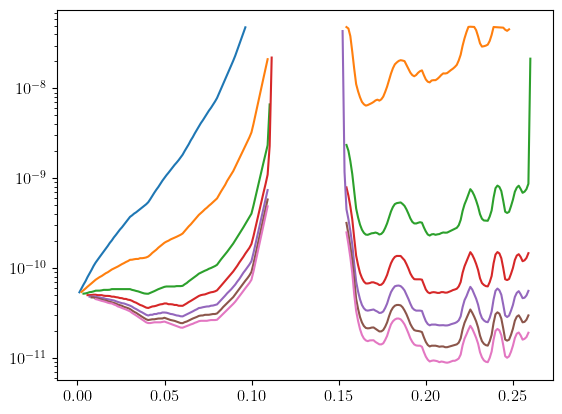

In [41]:
plt.semilogy(ma, 10**matrix_res[:-1,0], label=r'$\tau_a = 100$ ps')
plt.semilogy(ma, 10**matrix_res[:-1,1], label=r'$\tau_a = 200$ ps')
plt.semilogy(ma, 10**matrix_res[:-1,2], label=r'$\tau_a = 500$ ps')
plt.semilogy(ma, 10**matrix_res[:-1,3], label=r'$\tau_a = 1$ ns')
plt.semilogy(ma, 10**matrix_res[:-1,4], label=r'$\tau_a = 2$ ns')
plt.semilogy(ma, 10**matrix_res[:-1,5], label=r'$\tau_a = 5$ ns')
plt.semilogy(ma, 10**matrix_res[:-1,6], label=r'$\tau_a = \infty$')

In [46]:
np.save('../../alpaca/experimental_data/invisible/na62_kpiInv.npy', matrix_res.T)

# $K\to\pi\mu\mu$ at NA48/2

In [4]:
df_kpimumu_1ns = pd.read_csv('kpimumu_1ns.csv')
df_kpimumu_10ns = pd.read_csv('kpimumu_10ns.csv')
df_kpimumu_100ns = pd.read_csv('kpimumu_100ns.csv')
df_kpimumu_10ps = pd.read_csv('kpimumu_10ps.csv')
df_kpimumu_100ps = pd.read_csv('kpimumu_100ps.csv')

In [5]:
interp_kpimumu_1ns = interp1d(df_kpimumu_1ns['ma_GeV'], np.log10(df_kpimumu_1ns['BR']), kind='linear', bounds_error=False)
interp_kpimumu_10ns = interp1d(df_kpimumu_10ns['ma_GeV'], np.log10(df_kpimumu_10ns['BR']), kind='linear', bounds_error=False)
interp_kpimumu_100ns = interp1d(df_kpimumu_100ns['ma_GeV'], np.log10(df_kpimumu_100ns['BR']), kind='linear', bounds_error=False)
interp_kpimumu_10ps = interp1d(df_kpimumu_10ps['ma_GeV'], np.log10(df_kpimumu_10ps['BR']), kind='linear', bounds_error=False)
interp_kpimumu_100ps = interp1d(df_kpimumu_100ps['ma_GeV'], np.log10(df_kpimumu_100ps['BR']), kind='linear', bounds_error=False)

Text(0, 0.5, '$\\mathrm{BR}(K^+ \\to \\pi^+ a)\\times \\mathrm{BR}(a\\to \\mu^+\\mu^-)$')

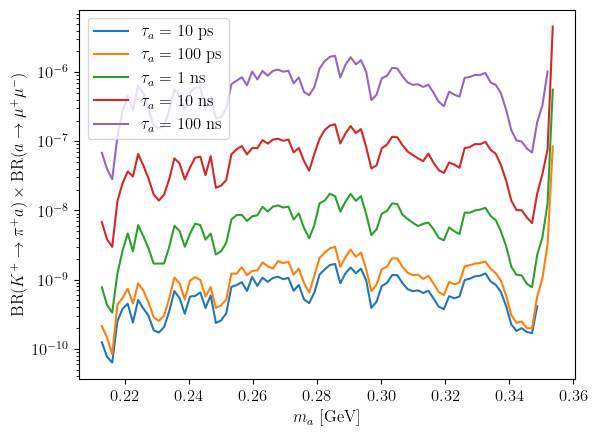

In [7]:
ma = np.linspace(0.2, 0.36, 100)
plt.semilogy(ma, 10**interp_kpimumu_10ps(ma), label=r'$\tau_a = 10$ ps')
plt.semilogy(ma, 10**interp_kpimumu_100ps(ma), label=r'$\tau_a = 100$ ps')
plt.semilogy(ma, 10**interp_kpimumu_1ns(ma), label=r'$\tau_a = 1$ ns')
plt.semilogy(ma, 10**interp_kpimumu_10ns(ma), label=r'$\tau_a = 10$ ns')
plt.semilogy(ma, 10**interp_kpimumu_100ns(ma), label=r'$\tau_a = 100$ ns')
plt.legend()
plt.xlabel(r'$m_a$ [GeV]')
plt.ylabel(r'$\mathrm{BR}(K^+ \to \pi^+ a)\times \mathrm{BR}(a\to \mu^+\mu^-)$')

In [8]:
matrix_res = np.full((101, 6), np.nan)
matrix_res[:-1,0] = interp_kpimumu_10ps(ma)
matrix_res[:-1,1] = interp_kpimumu_100ps(ma)
matrix_res[:-1,2] = interp_kpimumu_1ns(ma)
matrix_res[:-1,3] = interp_kpimumu_10ns(ma)
matrix_res[:-1,4] = interp_kpimumu_100ns(ma)
matrix_res[:-1,5] = ma
matrix_res[-1,:] = np.log10(np.array([10, 100, 1000, 10000, 100000, np.nan]))

In [9]:
np.save('../../alpaca/experimental_data/visible/na482_kpimumu.npy', matrix_res.T)

# $K\to\pi e^+ e^-$ at MicroBooNE

In [3]:
df_kpiee_10 = pd.read_csv('kpiee_10MeV.csv')
df_kpiee_50 = pd.read_csv('kpiee_50MeV.csv')
df_kpiee_100 = pd.read_csv('kpiee_100MeV.csv')
df_kpiee_120 = pd.read_csv('kpiee_120MeV.csv')
df_kpiee_150 = pd.read_csv('kpiee_150MeV.csv')
df_kpiee_180 = pd.read_csv('kpiee_180MeV.csv')
df_kpiee_210 = pd.read_csv('kpiee_210MeV.csv')

In [8]:
interp_kpiee_10 = interp1d(np.log10(df_kpiee_10['ctau_m']), np.log10(df_kpiee_10['BR']), kind='linear', bounds_error=False)
interp_kpiee_50 = interp1d(np.log10(df_kpiee_50['ctau_m']), np.log10(df_kpiee_50['BR']), kind='linear', bounds_error=False)
interp_kpiee_100 = interp1d(np.log10(df_kpiee_100['ctau_m']), np.log10(df_kpiee_100['BR']), kind='linear', bounds_error=False)
interp_kpiee_120 = interp1d(np.log10(df_kpiee_120['ctau_m']), np.log10(df_kpiee_120['BR']), kind='linear', bounds_error=False)
interp_kpiee_150 = interp1d(np.log10(df_kpiee_150['ctau_m']), np.log10(df_kpiee_150['BR']), kind='linear', bounds_error=False)
interp_kpiee_180 = interp1d(np.log10(df_kpiee_180['ctau_m']), np.log10(df_kpiee_180['BR']), kind='linear', bounds_error=False)
interp_kpiee_210 = interp1d(np.log10(df_kpiee_210['ctau_m']), np.log10(df_kpiee_210['BR']), kind='linear', bounds_error=False)

In [9]:
ctau = np.linspace(-1, 8, 200)

In [11]:
from alpaca.constants import c_nm_per_ps

matrix_res = np.full((201, 8), np.nan)
matrix_res[:-1,0] = interp_kpiee_10(ctau)
matrix_res[:-1,1] = interp_kpiee_50(ctau)
matrix_res[:-1,2] = interp_kpiee_100(ctau)
matrix_res[:-1,3] = interp_kpiee_120(ctau)
matrix_res[:-1,4] = interp_kpiee_150(ctau)
matrix_res[:-1,5] = interp_kpiee_180(ctau)
matrix_res[:-1,6] = interp_kpiee_210(ctau)
matrix_res[:-1,7] = ctau+9-np.log10(c_nm_per_ps)
matrix_res[-1,:] = np.array([10, 50, 100, 120, 150, 180, 210, np.nan])/1000

In [12]:
np.save('../../alpaca/experimental_data/visible/microboone_kpiee.npy', matrix_res)

# $K^+ \to \pi^+ \gamma \gamma$ at E787

In [14]:
df_kpigamma_1e11 = pd.read_csv('kpigamma_1e-11.csv')
df_kpigamma_1e10 = pd.read_csv('kpigamma_1e-10.csv')
df_kpigamma_1e9 = pd.read_csv('kpigamma_1e-9.csv')
df_kpigamma_1e8 = pd.read_csv('kpigamma_1e-8.csv')

In [15]:
interp_kpigamma_1e11 = interp1d(df_kpigamma_1e11['ma_GeV'], np.log10(df_kpigamma_1e11['BR']), kind='linear', bounds_error=False)
interp_kpigamma_1e10 = interp1d(df_kpigamma_1e10['ma_GeV'], np.log10(df_kpigamma_1e10['BR']), kind='linear', bounds_error=False)
interp_kpigamma_1e9 = interp1d(df_kpigamma_1e9['ma_GeV'], np.log10(df_kpigamma_1e9['BR']), kind='linear', bounds_error=False)
interp_kpigamma_1e8 = interp1d(df_kpigamma_1e8['ma_GeV'], np.log10(df_kpigamma_1e8['BR']), kind='linear', bounds_error=False)

In [16]:
ma = np.linspace(0, 0.1, 200)
matrix_res = np.full((201, 5), np.nan)
matrix_res[:-1,0] = interp_kpigamma_1e11(ma)
matrix_res[:-1,1] = interp_kpigamma_1e10(ma)
matrix_res[:-1,2] = interp_kpigamma_1e9(ma)
matrix_res[:-1,3] = interp_kpigamma_1e8(ma)
matrix_res[:-1,4] = ma
matrix_res[-1,:] = np.log10(np.array([1e-11, 1e-10, 1e-9, 1e-8, np.nan])*1e12)

In [17]:
np.save('../../alpaca/experimental_data/visible/e787_kpigamma.npy', matrix_res.T)